In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect

## Prepreprocess the Data
Here we split the data into train, test, and validation sets and drop non used columns (i.e. columns that are depecated)

In [ ]:
# Only run this once to create the splits.
if False:
    # Load the data
    df = pd.read_csv("community_notes.tsv", sep="\t")
    # Remove deperecated columns
    df = df.drop(columns=["believable", "harmful", "validationDifficulty"])
    # Drop rows with missing values and when summary note is using latin characters
    df = df.dropna()
    df = df[df["summary"].str.contains("[a-zA-Z]")]

    # We only want to keep english notes
    def detect_lang(text):
        try:
            return detect(text)
        except:
            return None

    df["language"] = df["summary"].map(detect_lang) == "en"
    df = df[df["language"]]
    print(df.shape)
    # Convert to train test validation split of 70/15/15%
    train = df.sample(frac=0.7, random_state=0)
    remaining = df.drop(train.index)
    test = remaining.sample(frac=0.5, random_state=0)
    validation = remaining.drop(test.index)

    train.to_csv("train.tsv", sep="\t", index=False)
    test.to_csv("test.tsv", sep="\t", index=False)
    validation.to_csv("validation.tsv", sep="\t", index=False)

/tmp/ipykernel_108717/3276169964.py:4: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("community_notes.tsv", sep="\t")


(1031004, 21)


Output after prepreprocessing
```python
>>> df.shape
>>> (1031004, 21)
```

In [70]:
# Load the train split
df_train = next(iter(pd.read_csv("train.tsv", sep="\t", chunksize=10_000)))

# Load the test split
df_test = next(iter(pd.read_csv("test.tsv", sep="\t", chunksize=10_000)))

Text(12, 5000.0, '50% of data')

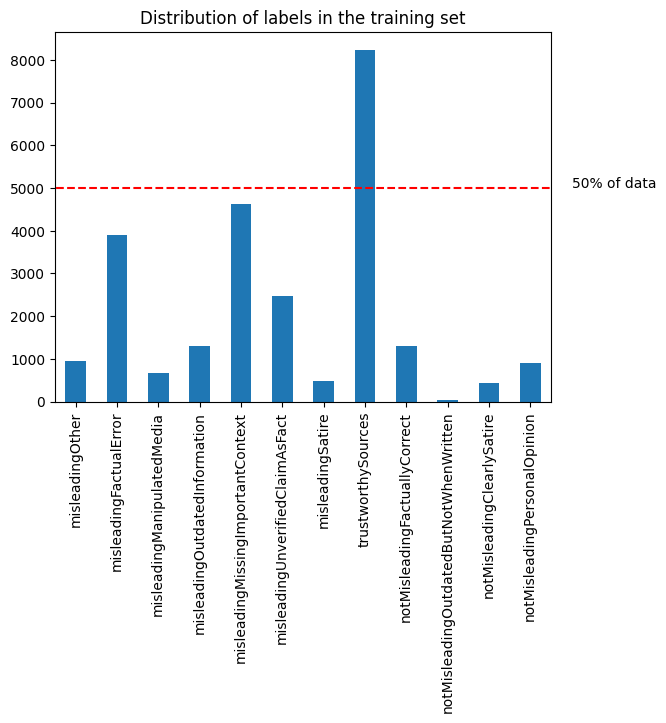

In [71]:
from enum import Enum


class OutputEnum(Enum):
    MISLEADING_OTHER = "misleadingOther"
    MISLEADING_FACTUAL_ERROR = "misleadingFactualError"
    MISLEADING_MANIPULATED_MEDIA = "misleadingManipulatedMedia"
    MISLEADING_OUTDATED_INFORMATION = "misleadingOutdatedInformation"
    MISLEADING_MISSING_IMPORTANT_CONTEXT = "misleadingMissingImportantContext"
    MISLEADING_UNVERIFIED_CLAIM_AS_FACT = "misleadingUnverifiedClaimAsFact"
    MISLEADING_SATIRE = "misleadingSatire"
    TRUSTWORTHY_SOURCES = "trustworthySources"
    NOT_MISLEADING_FACTUALLY_CORRECT = "notMisleadingFactuallyCorrect"
    NOT_MISLEADING_OUTDATED_BUT_NOT_WHEN_WRITTEN = (
        "notMisleadingOutdatedButNotWhenWritten"
    )
    NOT_MISLEADING_CLEARLY_SATIRE = "notMisleadingClearlySatire"
    NOT_MISLEADING_PERSONAL_OPINION = "notMisleadingPersonalOpinion"


# plot the distribution of the labels
relevant_columns = [label.value for label in OutputEnum]
df_train[relevant_columns].sum().plot(kind="bar")
plt.hlines(df_train.shape[0] / 2, -1, 12, colors="red", linestyles="dashed")
plt.title("Distribution of labels in the training set")
plt.text(12, df_train.shape[0] / 2, "50% of data")

## Bag of Words

In [79]:
from typing import NamedTuple
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score


class TestOutput(NamedTuple):
    score: float
    model: Pipeline


def test_pipeline(pipeline: Pipeline, output: str) -> TestOutput:
    pipeline.fit(df_train["summary"], df_train[output])
    pred = pipeline.predict(df_test["summary"])
    return TestOutput(
        score=balanced_accuracy_score(df_test[output], pred), model=pipeline
    )


OUTPUT = OutputEnum.MISLEADING_MANIPULATED_MEDIA.value
# Create a pipeline
bow_pipeline = make_pipeline(
    CountVectorizer(lowercase=True, stop_words="english", token_pattern=r"[a-z]{4,}"),
    LogisticRegression(),
)
tfidf_pipeline = make_pipeline(
    TfidfVectorizer(lowercase=True, stop_words="english", token_pattern=r"[a-z]{4,}"),
    LogisticRegression(),
)
test_pipeline(bow_pipeline, OUTPUT).score, test_pipeline(tfidf_pipeline, OUTPUT).score

(np.float64(0.6487519890097944), np.float64(0.5845749201925262))

In [80]:
for output in OutputEnum:
    print(f"==== {output.value} ====")
    print("BoW:", test_pipeline(bow_pipeline, output.value).score)
    print("TFIDF:", test_pipeline(tfidf_pipeline, output.value).score)
    print("")

==== misleadingOther ====
BoW: 0.6333749256481469
TFIDF: 0.6049745630216288

==== misleadingFactualError ====
BoW: 0.6556599872175646
TFIDF: 0.6612531381714434

==== misleadingManipulatedMedia ====
BoW: 0.6487519890097944
TFIDF: 0.5845749201925262

==== misleadingOutdatedInformation ====
BoW: 0.532376441059194
TFIDF: 0.5045519535221727

==== misleadingMissingImportantContext ====
BoW: 0.6742684188906499
TFIDF: 0.6760391781565565

==== misleadingUnverifiedClaimAsFact ====
BoW: 0.5873976237806063
TFIDF: 0.5397129800430304

==== misleadingSatire ====
BoW: 0.5228094072145998
TFIDF: 0.5010964912280702

==== trustworthySources ====
BoW: 0.9019571976644428
TFIDF: 0.730077274850118

==== notMisleadingFactuallyCorrect ====
BoW: 0.5998857142857142
TFIDF: 0.5506857142857143

==== notMisleadingOutdatedButNotWhenWritten ====
BoW: 0.49994972347913524
TFIDF: 0.5

==== notMisleadingClearlySatire ====
BoW: 0.7375783896857502
TFIDF: 0.6764322914975297

==== notMisleadingPersonalOpinion ====
BoW: 0.70642

# Language Model
Use a language model to predict